In [1]:
# обновить, без кеша, перезапустить.
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


# Сегментация изображений


При детекции объектов на изображении положение и размер объекта определяется ограничивающим окошком. Но такой подход не дает информации о *форме* объекта, все объекты ограничиваются прямоугольными рамками.

Для ряда задач важно понимать и форму объекта. Например, в задачах определения опухолей на мед. снимке мало просто указать где эта опухоль находится, требуется точно очертить ее, выделить границы и внутреннюю часть.

Вообще, необходимо каждый пиксель изображения отнести к какому-либо классу и\или объекту. Такую задачу называют **сегментацией** изображений.

Следует различать несколько постановок задач сегментации:
- **семантическая** сегментация (semantic segmentation), когда нас интересует к какому *классу* объектов принадлежит пиксель, в том числе разделить фоновые и не фоновые объекты.
- **по объектовая** сегментация (instance segmentation), когда нас интересует к какому конкретному объекту принадлежит пиксель. Даже если объекты одного класса, то результат сегментации должен показывать не только класс, но и номер (индекс) объекта.
- **паноптическая** сегментация ( [panoptic segmentation](https://analyticsindiamag.com/semantic-vs-instance-vs-panoptic-which-image-segmentation-technique-to-choose/) ), компромиссный вариант, когда для важных объектов требуется сделать по объектовую сегментацию, а для неважных (фон) достаточно семантической, не различая отдельные объекты.



![img](https://www.researchgate.net/profile/Andra-Petrovai/publication/329616112/figure/fig2/AS:739657281175556@1553359446925/Panoptic-segmentation-by-unifying-semantic-and-instance-segmentation_W640.jpg)


# Семантическая сегментация. Архитектура UNet

Для семантической сегментации требуется для каждого пикселя указать, к какому классу он относится. Значит выход нашей модели должен иметь такой же пространственный размер, что и исходное изображение.
Делаем такую сеть, обучаем, и задача, казалось бы, решена. Разумеется для обучения существуют наборы данных, в которых представлены изображения и соответствующие им **маски** - представление в форме изображения, которое показывает к какому классу относятся пиксели. В наших примерах такие маски будут бинарными, показывать принадлежит ли пиксель классу или нет. Очевидно, из бинарных масок можно собрать многоклассовую, где для каждого класса будет использована своя бинарная маска.


Для решения такой задачи подойдет архитектура UNet. Как и в задачах классификации будем для исходного изображения получать все более и более абстрактные карты признаков с помощью сверточных слоев и слоев субдискретизации.

Затем из самой абстрактной (читай, маленькой) карты признаков попытаемся восстановить маску изображения. Для этого придется увеличивать пространственные размеры карт признаков, ведь маска имеет те же пространственные размеры, что и исходное изображение.

Как увеличивать пространственные размеры карт признаков? Ответ - транспонированная свертка.

![img](https://drive.google.com/uc?id=1WGWP_6vChbrniMGR4_HDtL5sOPa6eEZ5)  



Есть проблема, которая усложняет решение задачи сегментации по сравнению с детекцией. Требование к точности гораздо больше! Если мы даже ошибемся на половину размера объекта с положением ограничивающего окошка, то объект-то все равно определим. Но для сегментации это будет слишком большая погрешность. Точность требуется чуть-ли не пиксельная, а иначе мы нарушаем форму объекта.

Когда мы восстанавливаем маску из самой абстрактной, т.е. маленькой, карты признаков, то в ней потеряно много деталей. Каждый признак отвечает за множество пикселей на исходном изображении. Значит нужно сохранить детальную информацию, которая получается на картах признаков с предыдущих слоев.

Так и сделали. Давайте будем сокращать в два раза пространственные размеры карт признаков и запоминать эти карты. А потом, когда будем увеличивать размеры (также в два раза) карт, будем использовать дополнительно (конкатенированием) и эти, запомненные с прошлых слоев,  карты. Получилась архитектура, как на рисунке. Почему ее назвали UNet?

![img](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png)






# UNet
Теперь архитектура известна, давайте ее реализуем. К слову, все операции дифференцируемые, нет проблем с обучением сети градиентными методами.

Будем использовать набор данных [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) в котором содержатся изображения кошек и собак разных пород, по одному объекту на изображение, и *маски* выделяющие объекты (т.е. отделяют их от фона). Есть и другая не нужная нам информация, мы ее выкинем.

![img](https://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)




Подключим все библиотеки

In [1]:
# работа с файлами
import os

# обработка и рисование изображений
import imageio
from PIL import Image

# рисование графиков
import matplotlib.pyplot as plt

import numpy as np # для работы с массивами

# для создание модели
import tensorflow as tf
# Слои, которые потребуются
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose # транспонированная свертка
from tensorflow.keras.layers import concatenate # объединение тензоров

from tensorflow.keras.losses import binary_crossentropy # функция ошибки
from sklearn.model_selection import train_test_split # разделение данных на обучающее и проверочное множества

### загрузка и предобработка данных
- маски хранятся как файлы png, изображения как jpg, названия одинаковые.
- в файлах есть мусор не нужный нам, а именно, файлы mat, файлы png с названиями начинающимися на ".", их выбросим.
- по-хорошему надо сортировать по имени файлы изображений и масок, чтобы соответствовали друг-другу.

In [2]:
# Загрузка данных
def LoadData (path1, path2):
    """
    Принимает пути к директориям с 1-изображениями и 2-масками
    Возвращает два списка: пути к файлам изображения и масок
    """
    # читаем все файлы директории
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)

    # делаем список файлов
    orig_img = []
    mask_img = []
    for file in image_dataset:
      if file[-4:]!='.mat': # пропускаем мусорные файлы
        orig_img.append(file)
    for file in mask_dataset:
      if file[0]!='.': # пропускаем мусорные файлы
        mask_img.append(file)

    # Сортируем по имени
    orig_img.sort()
    mask_img.sort()

    return orig_img, mask_img

Предобработка.

In [3]:
# предобработка данных
def PreprocessData(img, # изображения
                   mask, # маски
                   target_shape_img, # требуемый размер изображения
                   target_shape_mask,#  требуемый размер маски
                   path1, # директория с изображениями
                   path2): # директория с масками
    """
    Изображения трехканальные. Маски одноканальные.
    """
    # требуемые размеры
    m = len(img)                     # число примеров
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask

    # Массивы для изображений и масок, измерение 0 - примеры.
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32) # изображения как числа с плавающей точкой
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32) # маски (они же классы) целые числа.

    # Изменяем размеры
    for file in img:
        # Обработка изображений (3 канала)
        index = img.index(file) # индекс в массиве
        path = os.path.join(path1, file) # путь к файлу изображения
        single_img = Image.open(path).convert('RGB') # открываем и конвертируем в RGB
        single_img = single_img.resize((i_h,i_w)) # изменяем размер
        single_img = np.reshape(single_img,(i_h,i_w,i_c)) # нужные размеры массива
        single_img = single_img/255. # приводим диапазон значений пикселей к 0...1 в float32
        X[index] = single_img

        # Обработка масок (1 канал)
        single_mask_ind = mask[index] # индекс в массиве
        path = os.path.join(path2, single_mask_ind) # путь к файлу маски
        single_mask = Image.open(path) # открываем, конвертировать не надо, оно и так бинарное
        single_mask = single_mask.resize((m_h, m_w)) # изменяем размер
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c))  # нужные размеры массива
        single_mask = single_mask - 1 # нумерация классов должна начинаться с 0 (было 1,2)
        y[index] = single_mask
    return X, y

## Создаем UNet


### Блок кодера

Блок кодера понижает пространственные размеры в два раза. Состоит из слоев сверток и субдискретизации, использует слои dropout и BatchNormalization. Активация relu.  

In [4]:
# Блок кодера
def EncoderMiniBlock(inputs, # вход
                     n_filters=32, # количество фильтров
                     dropout_prob=0.3, # вероятность отброса
                     max_pooling=True): # использовать ли субдискретизацию

    # Два сверточных слоя (выходы) с инициализацией.
    # Набивка 'Same' не изменяет пространственные размеры.
    conv = Conv2D(n_filters,
                  3,   # размер ядра
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs) # инициализация (только при создании)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Нормализация
    conv = BatchNormalization()(conv, training=False)

    # dropout, если задан
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Субдискретизация, если задано. Конкретно MaxPooling, уменьшает пространственные размеры в два раза
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv

    # выход слоев ДО субдискретизации, будет передаваться в другие блоки.
    skip_connection = conv

    return next_layer, skip_connection # возвращаем выход блока и выход слоев до субдискретизации

### Блок декодера.
Принимает выход предыдущего слоя и выход заданного блока кодера.

- Увеличивает в два раза пространственные размеры выхода предыдущего слоя за счет транспонированной свертки.
- Конкатенирует результат с полученным выходом блока кодера.
- Применяет два сверточных слоя не изменяющих пространственные размеры.


In [5]:
# Блок декодера
def DecoderMiniBlock(prev_layer_input, # выход предыдущего слоя (блока)
                     skip_layer_input, # выход соответствующего блока кодера
                     n_filters=32): # число фильтров

    # Транспонированная свертка увеличивает пространственный размер карты признаков в два раза
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # размер ядра
                 strides=(2,2), # увеличение размера (обратите внимание для транспонированной свертки это увеличивает размер)
                 padding='same')(prev_layer_input) # набивка, чтобы не уменьшался размер при выполнении свертки

    # Конкатенируем по каналам (измерение 3) выход транспонированной свертки и выход блока кодера
    merge = concatenate([up, skip_layer_input], axis=3)

    # Две свертки не изменяющие размеры, с инициализацией
    conv = Conv2D(n_filters,
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

### Собираем UNet
Сеть UNet состоит из:

- 4 блоков кодера с понижением размеров карт признаков, но увеличением числа каналов.
- одного блока кодера без понижения размера.
- 4 блоков декодера с повышением размера карт признаков и понижением числа каналов.
- сверточного слоя не изменяющего размеры.
- выходного сверточного слоя с числом фильтров по количеству классов.





In [6]:
def UNetCompiled(input_size=(128, 128, 3), # размер изображения-входа
                 n_filters=32, # базовое число фильтров
                 n_classes=3): # число классов

    # Вход в сеть заданного размера
    inputs = Input(input_size)

    # Кодер
    # блок 1 принимает вход в сеть, число фильтров базовое, dropout нет, понижает размеры карты
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    # блок 2 принимает выход блока 1 (обратите внимание что блоки кодера возвращают два выхода),
    # число фильтров в два раза больше, dropout нет, понижает размеры карты
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    # блок 3 принимает выход блока 2, число фильтров еще в два раза больше, dropout нет, понижает размеры карты
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    # блок 4 принимает выход блока 3, число фильтров еще в два раза больше, dropout есть, понижает размеры карты
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    # блок 5 принимает выход блока 4, число фильтров еще в два раза больше, dropout есть, НЕ понижает размеры карты
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Декодер
    # блок 6 принимает выход блока 5, и второй выход (т.е. до слоя субдискретизации) блока 4,
    # число фильтров в два раза меньше чем у блока 5, повышает размеры карты
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    # блок 7 принимает выход блока 6, и второй выход блока 3, число фильтров в два раза меньше, повышает размеры карты
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    # блок 8 принимает выход блока 7, и второй выход блока 2, число фильтров в два раза меньше, повышает размеры карты
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    # блок 9 принимает выход блока 8, и второй выход блока 1, число фильтров в два раза меньше, повышает размеры карты
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # слой свертки без изменения размеров карты, число фильтров как у предыдущего блока
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    # слой свертки без изменения размеров карты, число фильтров по количеству классов
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Создаем модель из слоев
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

## Эксперименты

Скачиваем и загружаем данные.

In [7]:

import gdown
# изображения
#url='https://drive.google.com/uc?export=download&confirm=t&id=1LjItdLwag0eZflZAv3m3pKC0TxvIFP3_'
output = 'images.tgz'
file_id='1LjItdLwag0eZflZAv3m3pKC0TxvIFP3_'
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=t&id={file_id}",
    output
)
!tar -xzf "./images.tgz"

Downloading...
From (original): https://drive.google.com/uc?export=download&confirm=t&id=1LjItdLwag0eZflZAv3m3pKC0TxvIFP3_
From (redirected): https://drive.usercontent.google.com/download?id=1LjItdLwag0eZflZAv3m3pKC0TxvIFP3_&export=download&confirm=t&uuid=2ff03914-9641-46e6-a7c7-b62714dc589c
To: /content/images.tgz
100%|██████████| 792M/792M [00:10<00:00, 72.9MB/s]


In [8]:
# маски
url = 'https://drive.google.com/uc?export=download&confirm=t&id=12FRRT0QBYHYIYaVkxTyZi4eVdUVWjp5u'
output = 'annotations.tgz'
gdown.download(url, output, quiet=False)
!tar -xzf "./annotations.tgz"

Downloading...
From (original): https://drive.google.com/uc?export=download&confirm=t&id=12FRRT0QBYHYIYaVkxTyZi4eVdUVWjp5u
From (redirected): https://drive.usercontent.google.com/download?id=12FRRT0QBYHYIYaVkxTyZi4eVdUVWjp5u&export=download&confirm=t&uuid=fb2e099a-71d0-422f-838c-ab9d9adff82a
To: /content/annotations.tgz
100%|██████████| 19.2M/19.2M [00:00<00:00, 64.3MB/s]


In [9]:
# загружаем
path1 = 'images/'
path2 = 'annotations/trimaps/'
img, mask = LoadData (path1, path2)


Посмотрим на некоторые данные.

<ipython-input-10-6b9f13a0d047>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_view  = imageio.imread(path1 + img[i]) # путь к изображению
<ipython-input-10-6b9f13a0d047>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_view = imageio.imread(path2 + mask[i]) # путь к его маске


(500, 420, 3)
(500, 420)
(335, 500, 3)
(335, 500)


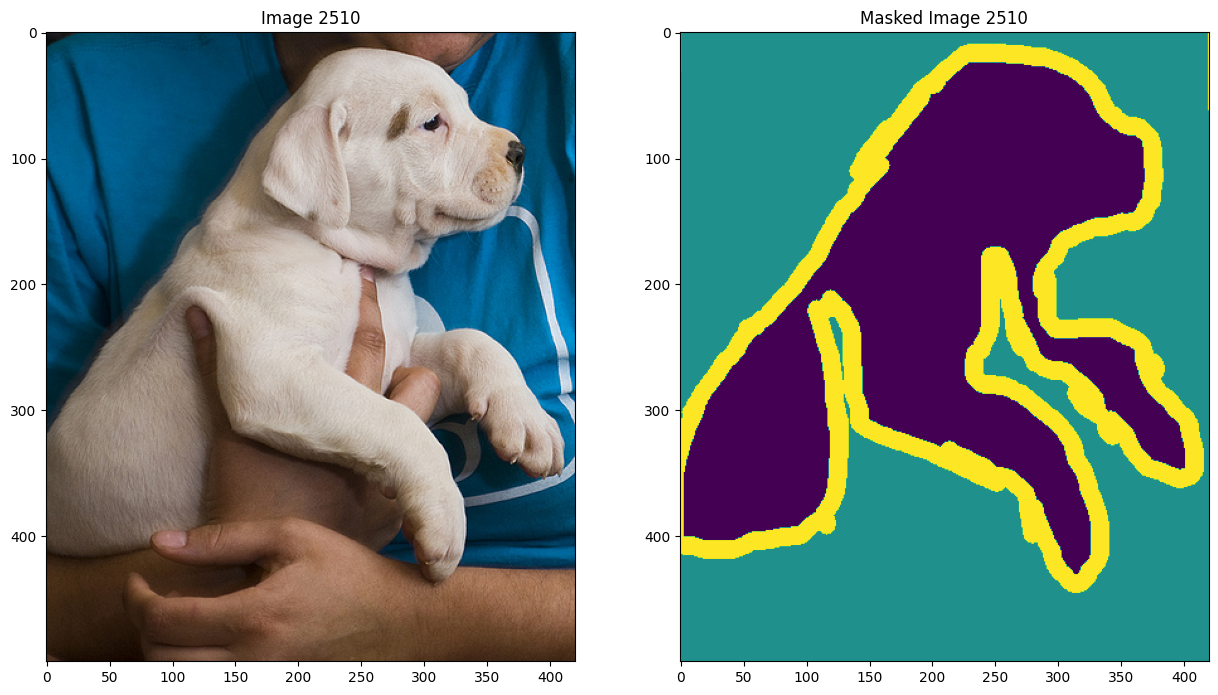

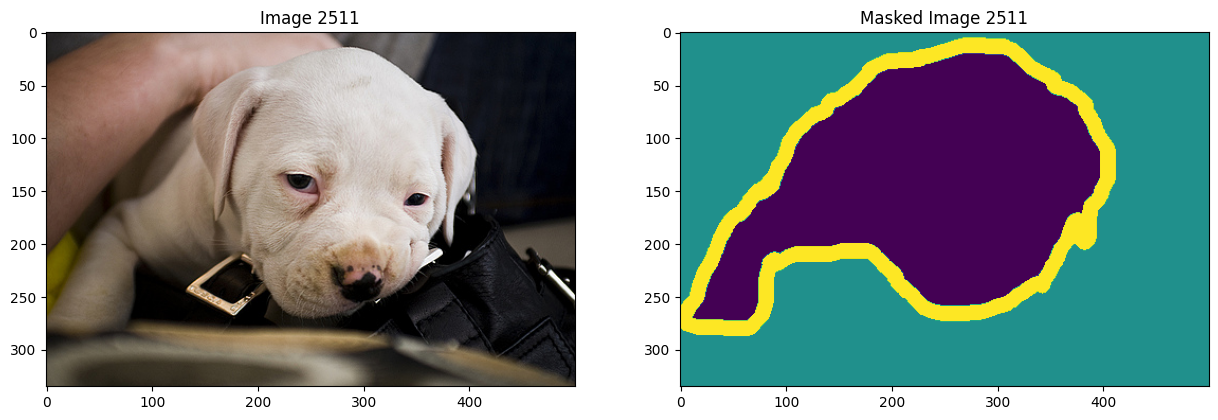

In [10]:

# рисуем изображения и маски
start_img = 2510 #
stop_img = 2512
for i in range(start_img, stop_img):
    img_view  = imageio.imread(path1 + img[i]) # путь к изображению
    mask_view = imageio.imread(path2 + mask[i]) # путь к его маске

    print(img_view.shape)
    print(mask_view.shape)
    #print(mask_view.min(), mask_view.max())
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view) # рисуем изображение
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view) # рисуем маску
    arr[1].set_title('Masked Image '+ str(i))

В масках представлено только три класса  - фон, контур, внутренность объекта (независимо от вида объекта).  

Предобработка

X Shape: (7390, 128, 128, 3)
Y shape: (7390, 128, 128, 1)
[0 1 2]


Text(0.5, 1.0, 'Processed Masked Image ')

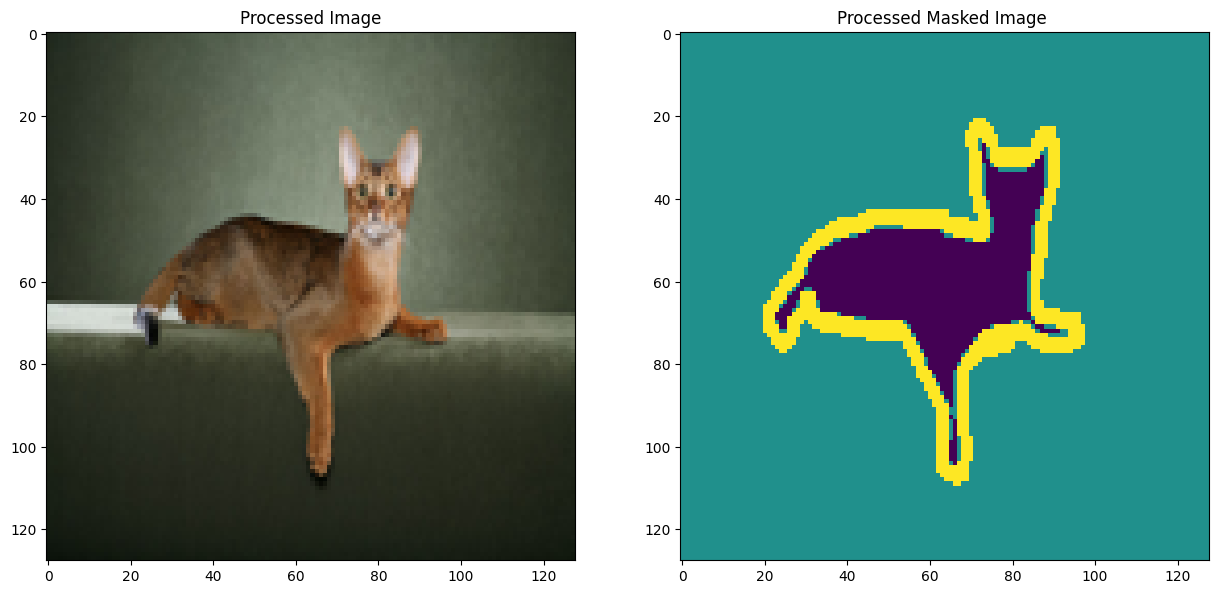

In [11]:
target_shape_img = [128, 128, 3] # размер изображений
target_shape_mask = [128, 128, 1] # размер масок

# обрабатываем
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

#
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# Классы : фон, объект, контур
print(np.unique(y))

# отображаем обработанные изображения и маски
image_index = 0
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

Разделяем данные на обучающие 80% и проверочные 20% случайно.

In [12]:

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

Создаем сеть, 3 класса, 32 базовых каналов.

In [13]:

unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=3)

In [14]:
# посмотрим на сеть
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d_1[0][0]']            
 Normalization)                                                                               

Задаем параметры обучения и обучаем сеть.

In [15]:
# оптимизатор Adam, функция ошибки - кроссэнтропия которая применяет softmax к выходам сети, метрика - аккуратность
unet.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# Обучаем ~ 10 минут (увеличьте число эпох)
results = unet.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
185/185 [==============================] - 73s 272ms/step - loss: 0.7639 - accuracy: 0.6730 - val_loss: 0.6050 - val_accuracy: 0.7542
Epoch 2/10
185/185 [==============================] - 42s 225ms/step - loss: 0.5564 - accuracy: 0.7799 - val_loss: 0.5045 - val_accuracy: 0.8047
Epoch 3/10
185/185 [==============================] - 43s 234ms/step - loss: 0.4612 - accuracy: 0.8214 - val_loss: 0.4577 - val_accuracy: 0.8170
Epoch 4/10
185/185 [==============================] - 43s 231ms/step - loss: 0.4132 - accuracy: 0.8413 - val_loss: 0.3919 - val_accuracy: 0.8472
Epoch 5/10
185/185 [==============================] - 43s 231ms/step - loss: 0.3801 - accuracy: 0.8555 - val_loss: 0.3889 - val_accuracy: 0.8505
Epoch 6/10
185/185 [==============================] - 43s 230ms/step - loss: 0.3635 - accuracy: 0.8616 - val_loss: 0.3920 - val_accuracy: 0.8498
Epoch 7/10
185/185 [==============================] - 43s 232ms/step - loss: 0.3412 - accuracy: 0.8708 - val_loss: 0.3761 - val_ac

### Проверяем работу модели

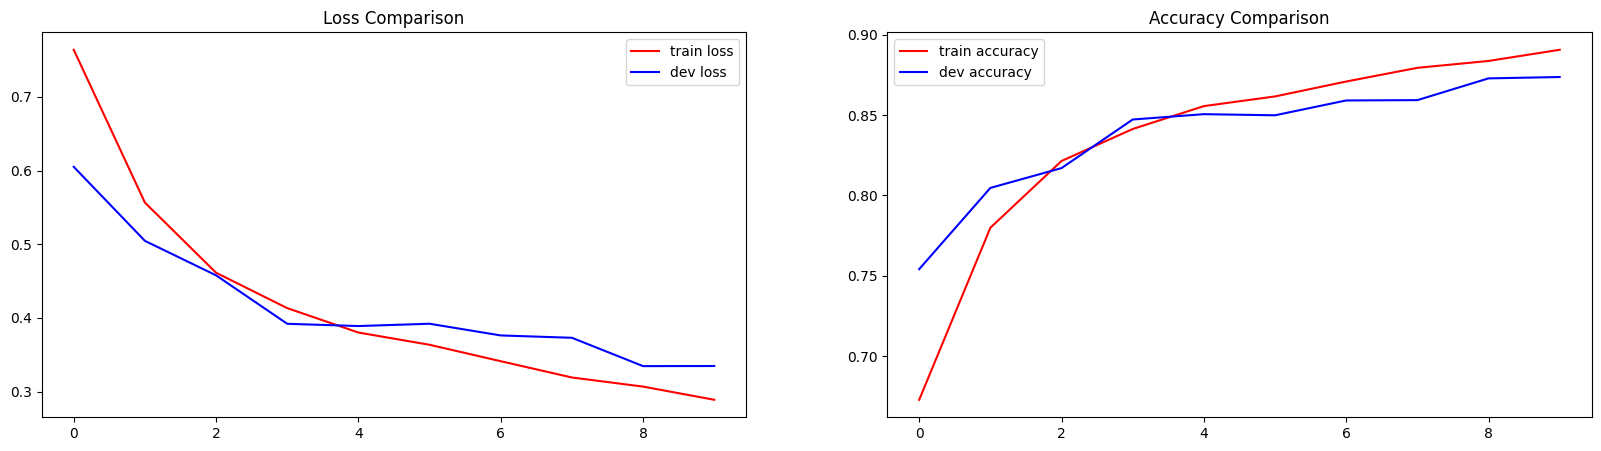

In [17]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()


Строим и сравниваем маски для проверочных данных

In [18]:
# оценка качества сети
unet.evaluate(X_valid, y_valid)

47/47 [==============================] - 2s 51ms/step - loss: 0.3346 - accuracy: 0.8736


[0.33463650941848755, 0.8736340999603271]

In [19]:
# рисуем
def VisualizeResults(index):
    img = X_valid[index] # изображение
    img = img[np.newaxis, ...] # добавляем измерение примеров
    pred_y = unet.predict(img) # расчитываем маску
    pred_mask = tf.argmax(pred_y[0], axis=-1) # выбираем максимальный класс (канал - последнее измерение)
    pred_mask = pred_mask[..., tf.newaxis] # канальное измерение добавляем
    # рисуем
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

1/1 [==============================] - 1s 1s/step


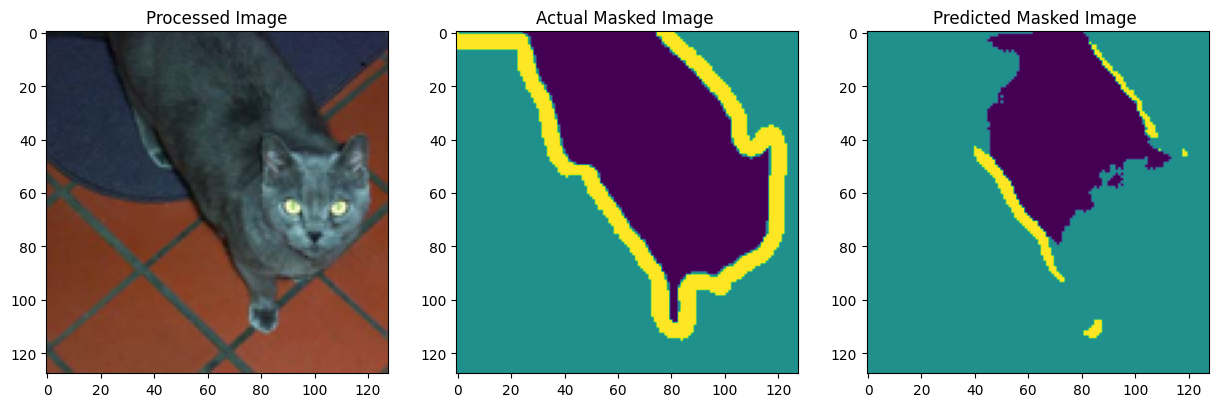

In [20]:
# рисуем
index = 200
VisualizeResults(index)

# Ссылки

Использованы и адаптированы материалы:

- https://medium.com/geekculture/u-net-implementation-from-scratch-using-tensorflow-b4342266e406
- https://colab.research.google.com/github/VidushiBhatia/U-Net-Implementation/blob/main/U_Net_for_Image_Segmentation_From_Scratch_Using_TensorFlow_v4.ipynb
- https://www.tensorflow.org/tutorials/images/segmentation

